# Voluntary Confinement

__authors__="Dominique Baril-Tremblay, Chantal Marlats, and Lucie Menager"\
__copyright__ = "Copyright 2020, Voluntary Confinement"\
__date__="November 4, 2020"\
__email__="doumbaril@gmail.com"\

## Cost of staying at home


I assumed the pandemic announcement occurred at $ t = 50$. I then divide the period between the announcement and the arrival of the vaccine into two equal segments: from the announcement (pol) to the period 200 and from the period 200 to the arrival of the vaccine. 

I assumed four different scenarios:
1. a subsidy leading to a reduction in the costs of staying at home in period 1 (Public Policy \# 1);
2. a subsidy leading to a reduction in the costs of staying at home in period 2 (Public Policy \# 2);
3. an increase in the costs of staying at home (Cabin Fever);
4. No subsidy or increase in costs (No Intervention).
I also added, when relevant, the curve of the SIR model.



In [1]:
import numpy as np
%matplotlib inline
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import math

matplotlib.rcParams['text.usetex'] = True
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## NOTES ##
# The variables indexed m are the variables of the modified SIR epidemiological model. 
# pol: Indicates at which period the epidemic was announced to the population.


# Total population, N.
N, Nm = 1, 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, Im0, Rm0 = 0.1/100, 0, 0.1/100, 0
# Everyone else, S0, is susceptible to infection initially.
S0, Sm0 = 1 - I0 - R0 , 1 -Im0 - Rm0


def BMM(pol,cp1,cp2):
    
    #Type distribution
    mu=0.2885 #proportion of asymptomatic

    #Initial beliefs
    Pm0=1-mu 
    
    #epidemiological parameters
    #Remuzzi A, Remuzzi G. COVID-19 and Italy: what next? Lancet 2020;2:10–3.
    brn=2.76       #Basic Reproduction Number
    gamma=1/(15)         #Recovery Rate
    dr=0.038            #Death Rate
    vs=(dr*gamma)/(1-dr)
    v=(1-mu)*(dr*gamma)/(1-dr)          #Death Probability
    beta=(brn*(gamma))     #Transmission Rate
    #print(beta)
    
    #behavioral parameters 
    r=0.00014
    CH=0.0009          #Cost of staying at home
    CI=0.09         #Cost of infection
    CD=9.00        #Cost of death
    VI=-(CI+CH+(vs*(CD/r)))/(gamma + r +vs)
    TH=350

    # A grid of time points (in days)
    t = np.linspace(0, TH, TH)
    
    #The SIR model differential equations.
    def deriv(y, t, beta, gamma, v):
        S, I, R = y
        dSdt = -(beta*I*S)
        dIdt = (beta*I*S) - (gamma*I) - (v*I)
        dRdt = (gamma*I) + (v*I)
        return dSdt, dIdt, dRdt 
    
    # The modified SIR model differential equations.
    def derivm(y, t, beta, gamma, v, CH, VI, r, TH, cp1, cp2, kt):
        Sm, Im, Pm = y
        if (kt is 0):
            kt=(CH)/(Pm*beta*Im*(-VI-(CH/r)*(1-math.exp(-r*(TH-t)))))
            if(kt>1):
                kt=1
        dSmdt = -(beta*Im*Sm*kt**2)
        dImdt = (beta*Im*Sm*kt**2) - (gamma*Im) - (v*Im)
        dPmdt = -(Pm*(1-Pm)*beta*Im*kt**2)
        return dSmdt, dImdt, dPmdt
    
    # The modified SIR model differential equations.
    def derivm1(y, t, beta, gamma, v, CH, VI, r, TH, cp1, cp2, kt):
        Sm, Im, Pm = y
        if (kt is 0):
            kt=(CH*(cp1))/(Pm*beta*Im*(-VI-((cp1)*(CH/r))*(1-math.exp(-r*(TH-t)))))
            if(kt>1):
                kt=1
        dSmdt = -(beta*Im*Sm*kt**2)
        dImdt = (beta*Im*Sm*kt**2) - (gamma*Im) - (v*Im)
        dPmdt = -(Pm*(1-Pm)*beta*Im*kt**2)
        return dSmdt, dImdt, dPmdt
    
    # The modified SIR model differential equations.
    def derivm2(y, t, beta, gamma, v, CH, VI, r, TH, cp1, cp2, kt):
        Sm, Im, Pm = y
        if (kt is 0):
            kt=(CH*(cp2))/(Pm*beta*Im*(-VI-((cp2)*(CH/r))*(1-math.exp(-r*(TH-t)))))
            if(kt>1):
                kt=1
        dSmdt = -(beta*Im*Sm*kt**2)
        dImdt = (beta*Im*Sm*kt**2) - (gamma*Im) - (v*Im)
        dPmdt = -(Pm*(1-Pm)*beta*Im*kt**2)
        return dSmdt, dImdt, dPmdt

    
    # Initial conditions vectors (ICV)
    y0 = S0, I0, R0     
    
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(beta, gamma, v))
    S, I, R = ret.T
    
    #Effective Reproduction Number - SIR
    ernSIR=np.array(S*((beta)/((gamma)+(v))))
    
    # Initial conditions vectors modified SIR over 0 to pol.
    ym0 = Sm0, Im0, Pm0     
    
    # Integrate the SIR modified equations over 0 to pol.
    retm1 = odeint(derivm, ym0, t[0:pol], args=(beta, gamma, v, CH, VI, r , TH, cp1, cp2, 1))
    Sm1, Im1, Pm1 = retm1.T
    
    # Initial conditions vectors modified SIR starting at t=pol
    ym1 = Sm1[pol-1], Im1[pol-1], Pm1[pol-1]     
    
    # Integrate SIR modified over pol to TH
    retm2 = odeint(derivm1, ym1, t[pol:pol+150], args=(beta,gamma, v, CH, VI, r, TH, cp1, cp2, 0))
    Sm2, Im2, Pm2 = retm2.T


    # Initial conditions vectors modified SIR starting at t=pol
    ym2 = Sm2[149], Im2[149], Pm2[149]     
    
    # Integrate SIR modified over pol to TH
    retm3 = odeint(derivm2, ym2, t[pol+150:TH], args=(beta,gamma, v, CH, VI, r, TH, cp1, cp2, 0))
    Sm3, Im3, Pm3 = retm3.T 
    
    

    
    # Merging all integrated arrays for complete model

    Sm=np.concatenate((Sm1,Sm2,Sm3))
    Im=np.concatenate((Im1,Im2,Im3))
    Pm=np.concatenate((Pm1,Pm2,Pm3))
    
    
    # Recovered individuals in the modified version of the model
    Rm = 1 - Im - Sm

   
    # upperbound K(t) + Effective Reproduction Number - modified SIR
    ktm=[]
    ernSIRm=[]
    for i in range(0,TH):
        if i >= pol and i < pol+150:
            ktm.append(cp1*CH/(Pm[i]*beta*Im[i]*(-VI-(((cp1*CH)/r))*(1-np.exp(-r*(TH-i))))))
        elif i >= pol+150:
            ktm.append(cp2*CH/(Pm[i]*beta*Im[i]*(-VI-(((cp2*CH)/r))*(1-np.exp(-r*(TH-i))))))
        else:
            ktm.append(1)
        
        ernSIRm.append(Sm[i]*((beta*ktm[i]**2)/((gamma)+(v))))
    #ktm[pol:pol+150]=np.array((cp1)*CH/(Pm*beta*Im*(-VI-((((cp1)*CH)/r))*(1-np.exp(-r*(TH-t))))))
    #ktm[pol+150:pol+300]=np.array((cp2)*CH/(Pm*beta*Im*(-VI-((((cp2)*CH)/r))*(1-np.exp(-r*(TH-t))))))
    #ktm[ktm>1]=1
    


    
    deathSIR=np.array(v*I)
    deathSIRm=np.array(v*Im)

    return deathSIR, deathSIRm, S, I, R, Sm, Im, Rm, Pm, ktm, ernSIR, ernSIRm
   # main function with pol as parameter  


In [2]:
##Color definition##

#Rainbow#
rain1, rain2, rain3, rain4, rain5, rain6='#862d86','#0000ff','#009900','#ffcc00','#ff6600','#ff0000'
#From darker to light
#Blues#
blu1, blu2, blu3, blu4, blu5, blu6, blu7='#000033','#000080','#0000b3','#0000ff','#4d4dff','#8080ff','#b3b3ff'
#Reds#
red1, red2, red3, red4, red5, red6, red7='#330000','#660000','#990000','#cc0000','#ff0000','#ff3333','#ff6666'
#Greens#
gre1, gre2, gre3, gre4, gre5, gre6, gre7='#0d260d','#194d19','#267326','#339933','#40bf40','#66cc66','#8cd98c'
#Purples#
pur1, pur2, pur3, pur4, pur5, pur6, pur7='#260d26','#4d194d','#732673','#993399','#bf40bf','#cc66cc','#d98cd9'
#Oranges#
ora1, ora2, ora3, ora4, ora5, ora6, ora7='#4d1f00','#993d00','#cc5200','#ff6600','#ff8533','#ffa366','#ffc299'
#grey#
grey1, grey2, grey3, grey4, grey5, grey6, grey7='#000000','#404040','#666666','#808080', '#a6a6a6','#bfbfbf', '#e6e6e6'


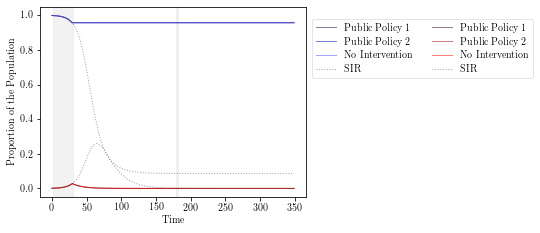

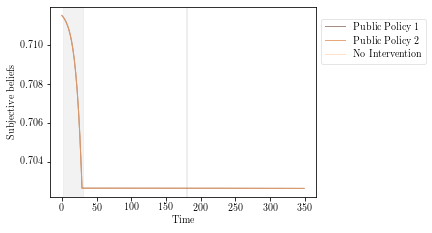

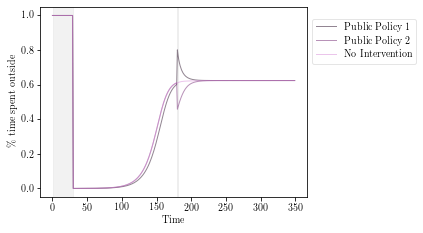

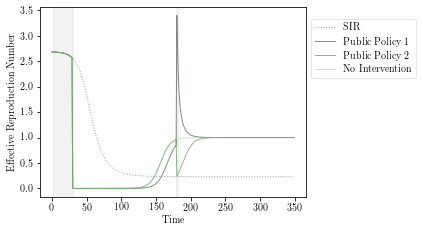

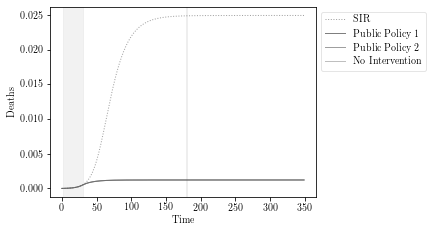

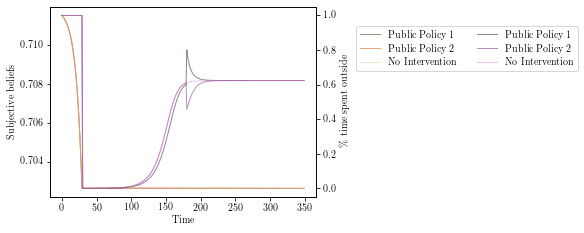

In [5]:
def toplot(values):
    x=[]
    for value in range(len(values)):
        x.append(np.array(values[value]))
    return x

#Susceptible#
sm10, sm20, sm30, sm40, sm00 = toplot([BMM(30,0.75,1)[5],
                                      BMM(30,1,0.75)[5],
                                      BMM(30,1,1)[5],
                                      BMM(30,1,2)[5],
                                      BMM(30,1,1)[2]])

#Infected#
im10, im20, im30, im40,  im00 = toplot([BMM(30,0.75,1)[6],
                                      BMM(30,1,0.75)[6],
                                      BMM(30,1,1)[6],
                                      BMM(30,1,2)[6],
                                      BMM(30,1,1)[3]])


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(sm10, blu1,alpha=0.5, lw=1, label='Public Policy 1')
ax.plot(sm20, blu3,alpha=0.5, lw=1, label='Public Policy 2')
ax.plot(sm30, blu5,alpha=0.5, lw=1, label='No Intervention')
#ax.plot(sm40, blu7,alpha=0.5, lw=1, label='Cabin Fever')
ax.plot(sm00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(im10, red1,alpha=0.5, lw=1, label='Public Policy 1')
ax.plot(im20, red3,alpha=0.5, lw=1, label='Public Policy 2')
ax.plot(im30, red5,alpha=0.5, lw=1, label='No Intervention')
#ax.plot(im40, red7,alpha=0.5, lw=1, label='Cabin Fever')
ax.plot(im00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.set_xlabel('Time')
ax.set_ylabel('Proportion of the Population')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=2,bbox_to_anchor=(1.87, 0.78))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_Dyna.pdf',bbox_inches='tight')

#Pt#
pm10, pm20, pm30, pm40 = toplot([BMM(30,0.75,1)[8],
                                      BMM(30,1,0.75)[8],
                                      BMM(30,1,2)[8],
                                      BMM(30,1,1)[8]])

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(pm10, ora1,alpha=0.5, lw=1, label='Public Policy 1')
ax.plot(pm20, ora3,alpha=0.5, lw=1, label='Public Policy 2')
#ax.plot(pm30, ora5,alpha=0.5, lw=1, label='Cabin Fever')
ax.plot(pm40, ora7,alpha=0.5, lw=1, label='No Intervention')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=1,bbox_to_anchor=(1.43, 0.82))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_P.pdf',bbox_inches='tight')

#Kt#
km10, km20, km30, km40 = toplot([BMM(30,0.75,1)[9],
                                      BMM(30,1,0.75)[9],
                                      BMM(30,1,2)[9],
                                      BMM(30,1,1)[9]])

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(km10, pur1,alpha=0.5, lw=1, label='Public Policy 1')
ax.plot(km20, pur3,alpha=0.5, lw=1, label='Public Policy 2')
#ax.plot(km30, pur5,alpha=0.5, lw=1, label='Cabin Fever')
ax.plot(km40, pur7,alpha=0.5, lw=1, label='No Intervention')
ax.set_xlabel('Time')
ax.set_ylabel('$\%$ time spent outside')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=1,bbox_to_anchor=(1.43, 0.82))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_K.pdf',bbox_inches='tight')

#Kt#
ern00, ern10, ern20, ern30, ern40= toplot([BMM(30,1,1)[10],
                                      BMM(30,0.5,1)[11],
                                      BMM(30,1,0.5)[11],
                                      BMM(30,1,2)[11],
                                      BMM(30,1,1)[11]])

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ern00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(ern10, gre1,alpha=0.5, lw=1, label='Public Policy 1')
ax.plot(ern20, gre3,alpha=0.5, lw=1, label='Public Policy 2')
#ax.plot(ern30, gre5,alpha=0.5, lw=1, label='Cabin Fever')
ax.plot(ern40, gre7,alpha=0.5, lw=1, label='No Intervention')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=1,bbox_to_anchor=(1.43, 0.78))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_ERN.pdf',bbox_inches='tight')

#Deaths#
d00=np.cumsum(np.array(BMM(30,1,1)[0]))
d10=np.cumsum(np.array(BMM(30,0.75,1)[1]))
d20=np.cumsum(np.array(BMM(30,1,0.75)[1]))
d30=np.cumsum(np.array(BMM(30,1,2)[1]))
d40=np.cumsum(np.array(BMM(30,1,1)[1]))



fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(d00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(d10, grey1,alpha=0.5, lw=1, label='Public Policy 1')
ax.plot(d20, grey2,alpha=0.5, lw=1, label='Public Policy 2')
#ax.plot(d30, grey3,alpha=0.5, lw=1, label='Cabin Fever')
ax.plot(d40, grey4,alpha=0.5, lw=1, label='No Intervention')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_Death.pdf',bbox_inches='tight')


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM01=ax.plot(pm10, ora1,alpha=0.5, lw=1, label='Public Policy 1')
PM02=ax.plot(pm20, ora3,alpha=0.5, lw=1, label='Public Policy 2')
#PM03=ax.plot(pm30, ora5,alpha=0.5, lw=1, label='Cabin Fever')
PM04=ax.plot(pm40, ora7,alpha=0.5, lw=1, label='No Intervention')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K01=ax2.plot(km10, pur1,alpha=0.5, lw=1, label='Public Policy 1')
K02=ax2.plot(km20, pur3,alpha=0.5, lw=1, label='Public Policy 2')
#K03=ax2.plot(km30, pur5,alpha=0.5, lw=1, label='Cabin Fever')
K04=ax2.plot(km40, pur7,alpha=0.5, lw=1, label='No Intervention')
ax2.set_ylabel('$\%$ time spent outside')
COMB=PM01+PM02+PM04+K01+K02+K04
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(2, 0.78))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig("BMM_Covid19_CH_PK.pdf",bbox_inches='tight')



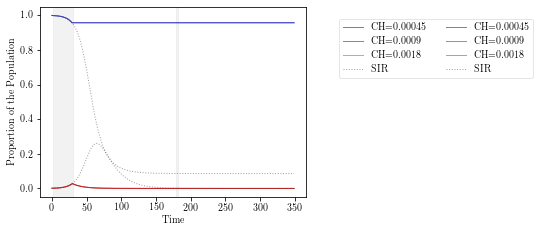

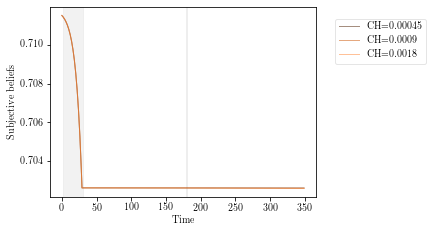

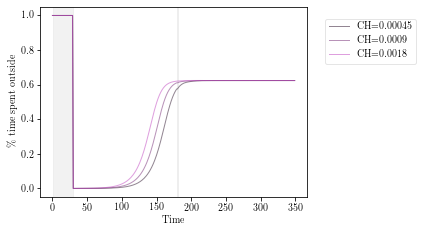

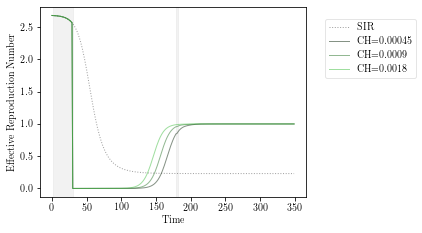

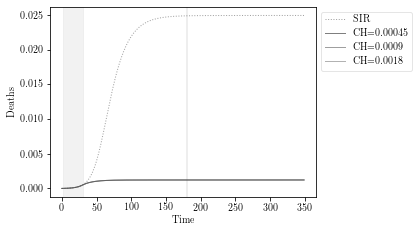

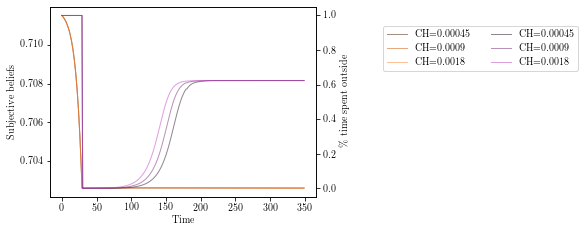

In [4]:
#Susceptible#
sm1, sm2, sm3, sm0 = toplot([BMM(30,0.5,0.5)[5],
                                      BMM(30,1,1)[5],
                                      BMM(30,1.5,1.5)[5],
                                      BMM(30,2,2)[2]])

#Infected#
im1, im2, im3, im0 = toplot([BMM(30,0.5,0.5)[6],
                                      BMM(30,1,1)[6],
                                      BMM(30,1.5,1.5)[6],
                                      BMM(30,2,2)[3]])


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(sm1, blu1,alpha=0.5, lw=1, label='CH=0.00045')
ax.plot(sm2, blu3,alpha=0.5, lw=1, label='CH=0.0009')
ax.plot(sm3, blu5,alpha=0.5, lw=1, label='CH=0.0018')
ax.plot(sm0, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(im1, red1,alpha=0.5, lw=1, label='CH=0.00045')
ax.plot(im2, red3,alpha=0.5, lw=1, label='CH=0.0009')
ax.plot(im3, red5,alpha=0.5, lw=1, label='CH=0.0018')
ax.plot(im0, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.set_xlabel('Time')
ax.set_ylabel('Proportion of the Population')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=2,bbox_to_anchor=(1.87, 0.78))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_Dyna0.pdf',bbox_inches='tight')

#Pt#
pm1, pm2, pm3 = toplot([BMM(30,0.5,0.5)[8],
                                      BMM(30,1,1)[8],
                                      BMM(30,2,2)[8]])

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(pm1, ora1,alpha=0.5, lw=1, label='CH=0.00045')
ax.plot(pm2, ora3,alpha=0.5, lw=1, label='CH=0.0009')
ax.plot(pm3, ora5,alpha=0.5, lw=1, label='CH=0.0018')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=1,bbox_to_anchor=(1.43, 0.82))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_P0.pdf',bbox_inches='tight')

#Kt#
km1, km2, km3 = toplot([BMM(30,0.5,0.5)[9],
                                      BMM(30,1,1)[9],
                                      BMM(30,2,2)[9]])

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(km1, pur1,alpha=0.5, lw=1, label='CH=0.00045')
ax.plot(km2, pur3,alpha=0.5, lw=1, label='CH=0.0009')
ax.plot(km3, pur5,alpha=0.5, lw=1, label='CH=0.0018')
ax.set_xlabel('Time')
ax.set_ylabel('$\%$ time spent outside')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=1,bbox_to_anchor=(1.43, 0.82))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_K0.pdf',bbox_inches='tight')

#Kt#
ern00, ern10, ern20, ern30= toplot([BMM(30,1,1)[10],
                                      BMM(30,0.5,0.5)[11],
                                      BMM(30,1,1)[11],
                                      BMM(30,2,2)[11]])

fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ern00, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(ern10, gre1,alpha=0.5, lw=1, label='CH=0.00045')
ax.plot(ern20, gre3,alpha=0.5, lw=1, label='CH=0.0009')
ax.plot(ern30, gre5,alpha=0.5, lw=1, label='CH=0.0018')
ax.set_xlabel('Time')
ax.set_ylabel('Effective Reproduction Number')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='center right', ncol=1,bbox_to_anchor=(1.43, 0.78))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_ERN0.pdf',bbox_inches='tight')

#Deaths#
d0=np.cumsum(np.array(BMM(30,1,1)[0]))
d1=np.cumsum(np.array(BMM(30,0.5,0.5)[1]))
d2=np.cumsum(np.array(BMM(30,1,1)[1]))
d3=np.cumsum(np.array(BMM(30,2,2)[1]))




fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(d0, grey2, linestyle=':', alpha=0.5, lw=1, label='SIR')
ax.plot(d1, grey1,alpha=0.5, lw=1, label='CH=0.00045')
ax.plot(d2, grey2,alpha=0.5, lw=1, label='CH=0.0009')
ax.plot(d3, grey3,alpha=0.5, lw=1, label='CH=0.0018')
ax.set_xlabel('Time')
ax.set_ylabel('Deaths')
ax.axvspan(1, 30, alpha=0.5, color= grey7)
ax.axvspan(179, 181, alpha=0.5, color= grey7)
legend = ax.legend(loc='best', ncol=1,bbox_to_anchor=(1, 1))
legend.get_frame().set_alpha(0.5)
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig('BMM_Covid19_CH_Death0.pdf',bbox_inches='tight')


fig = plt.figure(facecolor='w', figsize=[10,7])
ax = fig.add_subplot(111, axisbelow=True)
PM01=ax.plot(pm1, ora1,alpha=0.5, lw=1, label='CH=0.00045')
PM02=ax.plot(pm2, ora3,alpha=0.5, lw=1, label='CH=0.0009')
PM03=ax.plot(pm3, ora5,alpha=0.5, lw=1, label='CH=0.0018')
ax.set_xlabel('Time')
ax.set_ylabel('Subjective beliefs')
legend.get_frame().set_alpha(0.5)
ax2=ax.twinx()
K01=ax2.plot(km1, pur1,alpha=0.5, lw=1, label='CH=0.00045')
K02=ax2.plot(km2, pur3,alpha=0.5, lw=1, label='CH=0.0009')
K03=ax2.plot(km3, pur5,alpha=0.5, lw=1, label='CH=0.0018')
ax2.set_ylabel('$\%$ time spent outside')
COMB=PM01+PM02+PM03+K01+K02+K03
labs=[l.get_label() for l in COMB]
ax.legend(COMB, labs,loc='center right', ncol=2,bbox_to_anchor=(2, 0.78))
legend.get_frame().set_alpha(0.5)
ax2.tick_params(axis='y')
fig.set_size_inches(w=4.7747, h=3.5)
plt.savefig("BMM_Covid19_CH_PK0.pdf",bbox_inches='tight')

